# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 
*hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply 

* Use the Sobol results with N=100

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, ScalarOutcome, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [15]:
def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [18]:
model = Model("predprey", function=pred_prey)

model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter('predator_loss_rate', 0.04, 0.08)]

#List of the model outcomes must match.
model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

In [19]:
from ema_workbench import SequentialEvaluator, MultiprocessingEvaluator

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(1000)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [44]:
for var in outcomes.keys():
    outcomes[var] = outcomes[var][:,0,:]

In [60]:
x = experiments.iloc[:, :4]
y = outcomes["prey"][:, -1]

In [125]:
y

array([ 49.59543868,  50.91221892,  55.25835363,  17.77893769,
         7.06712224,  46.97837917,  13.59124661,   1.86812794,
        26.90929896,   7.29330669,  25.45088726,  50.59185627,
        18.63907168,  39.13971821,  23.43719789,  52.7816781 ,
         3.60048713,  29.55803777,  10.1980512 ,  16.38195511,
        12.54049029,  17.69755944,  24.79567217,  32.30086374,
        29.36602476,  46.63041815,  56.84793941,  47.38885945,
        31.11720908,  49.59839321,  10.55102333,   4.11314712,
        11.50955756,  12.49873232,  38.49312101,  17.8203449 ,
         8.55782423,  29.68913122,   7.44172298,  23.29229538,
        15.28596928,  18.82331361,  27.32918021,  42.92798857,
        35.66774787,  28.72383942,  30.67478638,  37.67357027,
         1.72336026,  51.08340435,   7.27654487,  20.9296191 ,
        15.2498991 ,   5.05280694,  22.03813984,  38.64805904,
        23.37421582,   1.45344863,  27.03899201,  53.65830446,
         2.90323585,   8.96376728,  40.52736836,  44.25

In [130]:
import statsmodels.api as sm
#Add a constant if there is no intercept
x_constant = sm.add_constant(x)
mod = sm.OLS(y, x_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     167.5
Date:                Mon, 13 May 2019   Prob (F-statistic):          1.11e-109
Time:                        16:39:43   Log-Likelihood:                -4187.7
No. Observations:                1000   AIC:                             8385.
Df Residuals:                     995   BIC:                             8410.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  37.7992    

In [90]:
y2 = []

for i in outcomes["prey"]:
    y2.append(i.mean())

In [139]:
mod = sm.OLS(y2, x_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     1720.
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        16:47:49   Log-Likelihood:                -2969.9
No. Observations:                1000   AIC:                             5950.
Df Residuals:                     995   BIC:                             5974.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  27.9411    

In [99]:
y3 = []

for i in outcomes["prey"]:
    y3.append(i.std())

In [140]:
mod = sm.OLS(y3, x_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     22.77
Date:                Mon, 13 May 2019   Prob (F-statistic):           5.09e-18
Time:                        16:47:55   Log-Likelihood:                -2605.5
No. Observations:                1000   AIC:                             5221.
Df Residuals:                     995   BIC:                             5246.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.1829    

# Sobol

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 
*hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply 

* Use the Sobol results with N=100

In [133]:
with SequentialEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000,
                                               uncertainty_sampling=SOBOL)

experiments, outcomes = sa_results

[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [134]:
for var in outcomes.keys():
    outcomes[var] = outcomes[var][:,0,:]
    
y4 = outcomes["prey"][:, -1]

In [194]:
problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, y4,
                   calc_second_order=True, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
predation_rate -0.002546 0.031442 0.132785 0.027970
predator_efficiency 0.407665 0.080675 0.809377 0.085459
predator_loss_rate 0.079809 0.064969 0.585974 0.060971
prey_birth_rate 0.030426 0.057928 0.511565 0.053232

Parameter_1 Parameter_2 S2 S2_conf
predation_rate predator_efficiency 0.009710 0.050339
predation_rate predator_loss_rate 0.001582 0.046314
predation_rate prey_birth_rate 0.009356 0.048024
predator_efficiency predator_loss_rate -0.063009 0.100405
predator_efficiency prey_birth_rate -0.049566 0.105206
predator_loss_rate prey_birth_rate 0.064763 0.082352


In [196]:
Si

{'S1': array([-0.00254622,  0.40766452,  0.07980894,  0.03042556]),
 'S1_conf': array([0.0314416 , 0.08067523, 0.0649693 , 0.05792755]),
 'ST': array([0.13278521, 0.80937657, 0.58597417, 0.51156524]),
 'ST_conf': array([0.02797011, 0.08545886, 0.06097092, 0.05323206]),
 'S2': array([[        nan,  0.00971004,  0.00158206,  0.00935598],
        [        nan,         nan, -0.06300859, -0.04956583],
        [        nan,         nan,         nan,  0.0647626 ],
        [        nan,         nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.05033914, 0.04631361, 0.04802437],
        [       nan,        nan, 0.10040524, 0.10520601],
        [       nan,        nan,        nan, 0.08235179],
        [       nan,        nan,        nan,        nan]])}

In [197]:
# import pandas as pd

# problem = get_SALib_problem(model.uncertainties)

# y = outcomes['prey'][:,0,-1]

# sobol_indices = sobol.analyze(problem, y)
# sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1','S1_conf']}
# sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])
# sobol_stats.sort_values(by='ST', ascending=False)

IndexError: too many indices for array

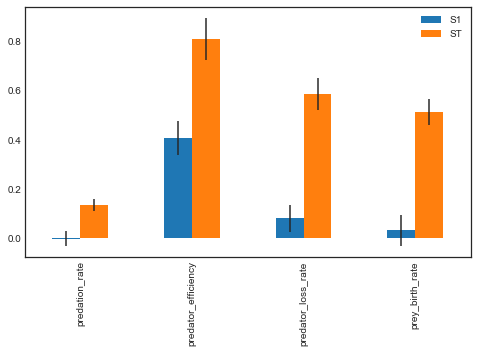

In [138]:
import seaborn as sns

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [121]:
# def analyze(results, ooi):
    '''analyze results using SALib sobol, returns a dataframe
    '''

    _, outcomes = results

    problem = get_SALib_problem(model.uncertainties)
    y = outcomes[ooi]
    sobol_indices = sobol.analyze(problem, y)
    sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1',
                                                       'S1_conf']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])
    sobol_stats.sort_values(by='ST', ascending=False)
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2_conf = pd.DataFrame(sobol_indices['S2_conf'], index=problem['names'],
                           columns=problem['names'])
    
    return sobol_stats, s2, s2_conf

sobol_stats, s2, s2_conf = analyze(sa_results, 'prey')

In [172]:
y5 = outcomes["prey"][:, -1].astype(int)

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [178]:
#If using classification you need integer
#If you have floats you use regression, you are trying to estimate a numerical value

scores, forest = feature_scoring.get_ex_feature_scores(experiments, y4, mode=RuleInductionType.REGRESSION, 
                                      nr_trees = 100, max_features = 0.6)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


In [200]:
scores

,1
0,
predator_efficiency,0.496306
prey_birth_rate,0.216707
predator_loss_rate,0.211350
predation_rate,0.049403
scenario,0.026234
